In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import rebound
plt.rcParams['font.size'] = 16

In [2]:
def remove_linear_trend(x):
    ts = np.arange(len(x))
    result = linregress(ts, x)
    return x - result.slope*ts - result.intercept

def get_transit_times(sim, plan, t_end=5*365.25):
    N = 2000
    transittimes = np.zeros(N)
    p = sim.particles
    i = 0
    while sim.t < t_end:
        y_old = p[plan].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
        t_old = sim.t
        sim.integrate(sim.t+0.05)
        t_new = sim.t
        if y_old*(p[plan].y-p[0].y)<0. and p[plan].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
                if y_old*(p[plan].y-p[0].y)<0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit
    return transittimes[transittimes != 0]

In [3]:
f, g = -2.025, 2.484
def make_sim(e_shift):
    sim = rebound.Simulation()
    sim.units = ('AU', 'd', 'Msun')
    sim.add(m=1.)
    e1 = 0.02*np.exp(1j*0)
    e2 = 0.02*np.exp(1j*np.pi)
    e1 += e_shift
    e2 += -f/g*e_shift
    sim.add(m=10/332900, P=2, e=np.abs(e1), pomega=np.angle(e1), l=0)
    sim.add(m=10/332900, P=3, e=np.abs(e2), pomega=np.angle(e2), l=0)
    sim.move_to_com()
    # sim.integrator = 'whfast'
    # sim.dt = 0.05
    return sim

def run_sim(sim, t_end=5*365.25):
    ps = sim.particles
    times = np.linspace(0, t_end, 1000)
    N = len(times)
    orbits = np.zeros((N, 8))
    for i in range(N):
        sim.integrate(times[i])
        orbits[i] = ps[1].a, ps[1].e, ps[1].pomega, ps[1].l, ps[2].a, ps[2].e, ps[2].pomega, ps[2].l
    phi_1 = np.remainder(3*orbits[:,7] - 2*orbits[:,3] - orbits[:,2] + np.pi, 2*np.pi) - np.pi
    phi_2 = np.remainder(3*orbits[:,7] - 2*orbits[:,3] - orbits[:,6], 2*np.pi)
    pomega_hat = np.angle(f*orbits[:,1]*np.exp(1j*orbits[:,2]) + g*orbits[:,5]*np.exp(1j*orbits[:,6]))
    psi = np.remainder(3*orbits[:,7] - 2*orbits[:,3] - pomega_hat, 2*np.pi)
    return times, phi_1, phi_2, psi

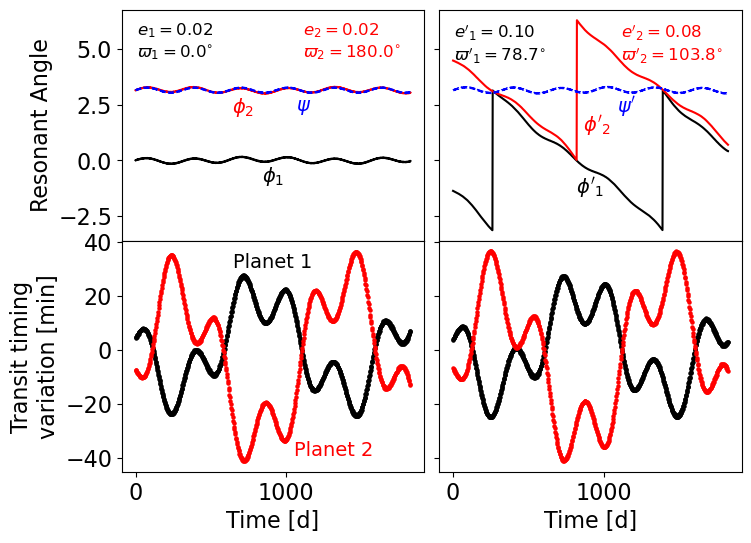

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='row', gridspec_kw={'hspace': 0., 'wspace': 0.05})
sim = make_sim(0.0*np.exp(1j*np.pi/4))

times, phi_1, phi_2, psi = run_sim(sim.copy())
transittimes_1 = get_transit_times(sim.copy(), 1)
transittimes_2 = get_transit_times(sim.copy(), 2)
axs[0,0].plot(times, phi_1, c='k')
axs[0,0].plot(times, phi_2, c='r')
axs[0,0].plot(times, psi, c='b', linestyle='--')
axs[0,0].text(0.05, 0.95, rf'$e_1={sim.particles[1].e:.2f}$' + '\n' + rf'$\varpi_1={np.degrees(sim.particles[1].pomega):.1f}' + '^{\circ}$', transform=axs[0,0].transAxes, va='top', ha='left', fontsize=12)
axs[0,0].text(0.6, 0.95, rf'$e_2={sim.particles[2].e:.2f}$' + '\n' + rf'$\varpi_2={np.degrees(sim.particles[2].pomega):.1f}' + '^{\circ}$', transform=axs[0,0].transAxes, va='top', ha='left', fontsize=12, c='r')
axs[0,0].text(0.5, 0.28, "$\phi_1$", transform=axs[0,0].transAxes, va='center', ha='center', fontsize=14)
axs[0,0].text(0.4, 0.58, "$\phi_2$", transform=axs[0,0].transAxes, va='center', ha='center', fontsize=14, c='r')
axs[0,0].text(0.6, 0.58, "$\psi$", transform=axs[0,0].transAxes, va='center', ha='center', fontsize=14, c='b')

axs[1,0].scatter(transittimes_1, remove_linear_trend(transittimes_1)*24*60, s=5, c='k');
axs[1,0].scatter(transittimes_2, remove_linear_trend(transittimes_2)*24*60, s=5, c='r');
axs[1,0].text(0.5, 0.95, 'Planet 1', transform=axs[1,0].transAxes, va='top', ha='center', fontsize=14, c='k')
axs[1,0].text(0.7, 0.05, 'Planet 2', transform=axs[1,0].transAxes, va='bottom', ha='center', fontsize=14, c='r')

sim = make_sim(0.1*np.exp(1j*np.pi/2))

times, phi_1, phi_2, psi = run_sim(sim.copy())
transittimes_1 = get_transit_times(sim.copy(), 1)
transittimes_2 = get_transit_times(sim.copy(), 2)
axs[0,1].plot(times, phi_1, c='k')
axs[0,1].plot(times, phi_2, c='r')
axs[0,1].plot(times, psi, c='b', linestyle='--')
axs[0,1].text(0.05, 0.95, rf"$e'_1={sim.particles[1].e:.2f}$" + '\n' + rf"$\varpi'_1={np.degrees(sim.particles[1].pomega):.1f}" + '^{\circ}$', transform=axs[0,1].transAxes, va='top', ha='left', fontsize=12)
axs[0,1].text(0.6, 0.95, rf"$e'_2={sim.particles[2].e:.2f}$" + '\n' + rf"$\varpi'_2={np.degrees(sim.particles[2].pomega):.1f}" + '^{\circ}$', transform=axs[0,1].transAxes, va='top', ha='left', fontsize=12, c='r')
axs[0,1].text(0.5, 0.23, "$\phi'_1$", transform=axs[0,1].transAxes, va='center', ha='center', fontsize=14)
axs[0,1].text(0.52, 0.5, "$\phi'_2$", transform=axs[0,1].transAxes, va='center', ha='center', fontsize=14, c='r')
axs[0,1].text(0.62, 0.58, "$\psi'$", transform=axs[0,1].transAxes, va='center', ha='center', fontsize=14, c='b')

axs[1,1].scatter(transittimes_1, remove_linear_trend(transittimes_1)*24*60, s=5, c='k');
axs[1,1].scatter(transittimes_2, remove_linear_trend(transittimes_2)*24*60, s=5, c='r');

axs[1,1].set_xlabel('Time [d]')
axs[1,0].set_xlabel('Time [d]')
axs[0,0].set_ylabel(r'Resonant Angle')
axs[1,0].set_ylabel('Transit timing\nvariation [min]')
plt.savefig('figs/resonant_angles.pdf', bbox_inches='tight')